In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
# plt.style.use('siads')

## 1. load training data

In [2]:
FILENAME = './DATA/cylinder_uv_area_siren_n_eco.npz'
# FILENAME = 'cylinder_n.npz'

# data has 6 colls:
# - Time,
# - x,
# - y, 
# - "x_velocity",
# - "y_velocity", 
# - "Area"
data=np.load(FILENAME)['data']
mean = np.load(FILENAME)['mean']
std = np.load(FILENAME)['std']
data_raw = data 

arr=np.diff(data_raw[:,0])>0
index_max_list=np.where(arr==1)[0]

In [3]:
data.shape

(966514, 6)

## 2. load models

In [4]:
RANK = 10

In [5]:
MODEL_NAME = 'NIF_SIREN_AREA_RANK_'+str(RANK)+'_NSX_300_LSX_3_NST_100_LST_3_1_VECPOD'
model_dir = './'+MODEL_NAME+'/saved_model_ckpt_1200'

In [6]:
sess = tf.Session(graph=tf.Graph())
MODEL_LOADED=tf.saved_model.loader.load(sess, ["serve"], model_dir)
graph = sess.graph

# load input tensors
INPUT_T = graph.get_tensor_by_name('input_T:0')
INPUT_Y = graph.get_tensor_by_name('input_Y:0')
INPUT_X = graph.get_tensor_by_name('input_X:0')

# ouput tensor
# OUTPUT_U = graph.get_tensor_by_name('output_u:0')
OUTPUT_PARA_NET = graph.get_tensor_by_name('para_net:0')
OUTPUT_PHI_X = graph.get_tensor_by_name('phi_x:0')

# evaluate on the training data
input_arr_t = data_raw[:,0].reshape(-1,1)
input_arr_x = data_raw[:,1].reshape(-1,1)
input_arr_y = data_raw[:,2].reshape(-1,1)

i_min = 0
i_max = index_max_list[0]+1

index_jump = (input_arr_t[1:]-input_arr_t[:-1])>0
# index_jump[0] = True
index_jump=np.append(index_jump,True)

single_t_array = input_arr_t[index_jump]

# plt.plot(single_t_array)

# print(single_t_array.shape)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./NIF_SIREN_AREA_RANK_10_NSX_300_LSX_3_NST_100_LST_3_1_VECPOD/saved_model_ckpt_1200/variables/variables


## compute temporal basis (latent variables) 

In [7]:
# single_t_array = np.linspace(-1,1,100,endpoint=True)
single_t_array = np.linspace(-1,1,500,endpoint=True)

single_t_array=single_t_array.reshape(-1,1)
# print(single_t_array.shape)

# obtain latent variables
output_arr_pn_single = sess.run(OUTPUT_PARA_NET, {INPUT_T:single_t_array})[:,:,0]

## compute spatial basis

In [8]:
# change spatial resolution
x_ = np.linspace(-1,1,500, endpoint=True)
y_ = np.linspace(-1,1,500, endpoint=True)

xx_, yy_ = np.meshgrid(x_,y_)
xx_ = xx_.reshape(-1,1)
yy_ = yy_.reshape(-1,1)

xx = xx_ * std[1] + mean[1]
yy = yy_ * std[2] + mean[2]

# xx = data_raw[i_min:i_max,1]*std[1]+mean[1]
# yy = data_raw[i_min:i_max,2]*std[2]+mean[2]

px = sess.run(OUTPUT_PHI_X, {INPUT_Y: yy_, INPUT_X:xx_ })

In [9]:
dx = xx[1,0]-xx[0,0]
dy = yy[501,0]-yy[0,0]
da = dx*dy
da = da

In [10]:
# compute norm of each component of spatial basis,
# note that they are evenly sampled in space... so it is different from the data.
# so for `px`, the inner product in space DOES NOT need any area weighting.

tmp_list = []
for i in range(RANK):
    
    c_i = da*np.linalg.norm(px[:,i])**2 + da*np.linalg.norm(px[:,i+RANK])**2
    sc_i = np.sqrt(c_i)
    
    print('i = ',i, ' square root of c_i = ', sc_i)
    tmp_list.append(sc_i)
    # normalized the spatial modes
    px[:,i] = px[:,i] / sc_i
    px[:,i+RANK] = px[:,i+RANK] / sc_i
    
scaling_array = np.array(tmp_list)

i =  0  square root of c_i =  0.0252010649165811
i =  1  square root of c_i =  0.024900663811374756
i =  2  square root of c_i =  0.028601857349409898
i =  3  square root of c_i =  0.026752698069495106
i =  4  square root of c_i =  0.02631639561953378
i =  5  square root of c_i =  0.023706054471395684
i =  6  square root of c_i =  0.028907711123442138
i =  7  square root of c_i =  0.02909378762062103
i =  8  square root of c_i =  0.02945776940858686
i =  9  square root of c_i =  0.026404657754738683


In [11]:
## sanity check, they should be 1 always
# for i in range(RANK):
#     tmp = da*np.linalg.norm(px[:,i])**2 + da*np.linalg.norm(px[:,i+RANK])**2
#     print(tmp)

In [12]:
# here for simplicity, we just approximate all dt as 5e-4, 
# although they do have a difference, due to the data sampling process that I used.
dt_list = []
dt_array_normalized = single_t_array[1:] - single_t_array[:-1]
dt_list = dt_array_normalized * std[0]

# dt = 5e-4
dt = dt_list[0]
L_char = 7e-3
U_inf = 3.

In [13]:
# scale the a(t) by * sqrt(c_i)
At = output_arr_pn_single
At = np.matmul(At, np.diag(scaling_array))

## Drawing latent representation

In [14]:
plt.figure(figsize=(30,6))
for i in range(RANK):
    plt.plot(At[:,i],'-',label=str(i+1),lw=2.5)

plt.xlabel('time $t$',fontsize=60)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.ylabel(r'latent rep. $\zeta$',fontsize=60)
plt.savefig('./'+MODEL_NAME+'/pngs/all_latent_rep.png',bbox_inches='tight',dpi=200)
plt.close()

## Compute DMD

In [15]:
def compute_dmd(X,dt,L_char,U_inf):
    X0 = X[:-1]
    X1 = X[1:]
    A=np.linalg.lstsq(X0, X1)[0].T
    D,P=np.linalg.eig(A)

    # a-posteriori evaluation
    x_list = [X0[0,:]]
    for i in range(X.shape[0]-1):
        x_list.append(A @ x_list[i])
    Xp = np.array(x_list)

    for j in range(X.shape[1]):
        plt.figure(figsize=(16,4))
        plt.plot(X[:,j],'k-o',label='true')
        plt.plot(Xp[:,j],'r--o',label='DMD')
        plt.xlabel('time',fontsize=30)
        plt.ylabel('x-'+str(j+1),fontsize=30)
        plt.legend(loc='upper right')
        plt.savefig('./'+MODEL_NAME+'/pngs/compare_latent_rep_'+str(j)+'.png',bbox_inches='tight')
        plt.close()
    
    print('residual = ',np.linalg.lstsq(X0, X1)[1])
    
    # a-priori temporal and spatial modes
    tm = X0 @ np.linalg.inv(P).T @ np.diag(D)
    sm = P.T
    
    
    
    # compute continuous DMD eigenvalue
    growth_rate = np.real(np.log(D))/dt
    freq = np.imag(np.log(D))/dt/(2*np.pi)
    
    # initial amplitute
    ampl = X0[0].reshape(1,-1) @ np.linalg.inv(P).T
    ampl = np.abs(ampl.ravel())
    
    st = freq*L_char / U_inf
    return ampl, growth_rate, st, tm, sm, D

In [16]:
ampl, growth_rate, st, tm, sm, D = compute_dmd(At,dt,L_char,U_inf)

/home/shaowu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


residual =  [4.86837618e-05 2.30793200e-05 4.23503431e-04 1.63214289e-05
 1.45235347e-04 9.53409889e-04 1.14109630e-05 5.28509184e-04
 6.85743486e-05 3.76917454e-04]


/home/shaowu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Draw DMD spectrum

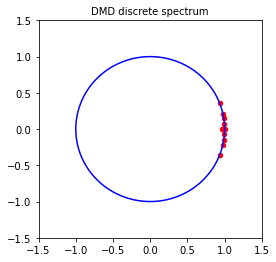

In [22]:
theta=np.linspace(0,6.28,100)
plt.figure(figsize=(4,4))
plt.plot(np.cos(theta),np.sin(theta),'b-')
plt.scatter(np.real(D),np.imag(D),s=20,c='r')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.title('DMD discrete spectrum',fontsize=10)
plt.savefig('./'+MODEL_NAME+'/pngs/dmd/discrete_spectrum.png',bbox_inches='tight')

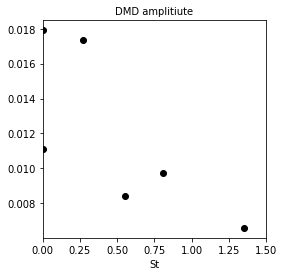

In [23]:
plt.figure(figsize=(4,4))
plt.scatter(st, ampl, c='k')
# plt.scatter(st, growth_rate, c='r',s=10)
plt.xlim([0,1.5])
# plt.ylim([0,3e2])
plt.title('DMD amplitiute',fontsize=10)
plt.xlabel('St')
plt.savefig('./'+MODEL_NAME+'/pngs/dmd/spectrum_freq.png',bbox_inches='tight')
# plt.close()

## visualize DMD modes

- note that it takes a lot of memory so I did it in a 'disk-IO' fashion

In [19]:
pxT=px.T

# save flcunctaion fields
for i in range(RANK):
    tmp = tm[:,[i]] @ sm[[i], :] 
    df_u_i = tmp @ pxT[:RANK,:] * std[-3]
    df_v_i = tmp @ pxT[RANK:] * std[-2]
    
    save_npz_path = './'+MODEL_NAME+'/pngs/' + 'decomposed_modes_'+str(i+1) + '.npz'
    np.savez(save_npz_path, df_u_i=np.real(df_u_i), df_v_i=np.real(df_v_i))

In [20]:
# remove negative st and ampl
i_st = np.arange(st.shape[0])
st_p = st[st>=0]
ampl_p = ampl[st>=0]
i_st_p = i_st[st>=0]
i_ordered_st_p = np.argsort(ampl_p)[::-1]

# order from max to min
i_st_p_ordered = i_st_p[i_ordered_st_p]

# remove repeated St,
i_st_p_ordered = np.delete(i_st_p_ordered, 2)

xx=xx.ravel()
yy=yy.ravel()

In [24]:
levels_list_u = [
    np.linspace(-6,6,31,endpoint=True),
    np.linspace(-2,2,31,endpoint=True),
    np.linspace(-0.5,0.5,31,endpoint=True),
    np.linspace(-0.7,0.7,31,endpoint=True),
    np.linspace(-0.2,0.2,31,endpoint=True),
]
levels_list_v = [
    np.linspace(-4,4,31,endpoint=True),
    np.linspace(-4,4,31,endpoint=True),
    np.linspace(-1,1,31,endpoint=True),
    np.linspace(-0.7,0.7,31,endpoint=True),
    np.linspace(-0.3,0.3,31,endpoint=True),
]

for ip, i in enumerate(i_st_p_ordered):
    # read decomposed fields from disk
    save_npz_path = './'+MODEL_NAME+'/pngs/' + 'decomposed_modes_'+str(i+1) + '.npz'
    df_u = np.load(save_npz_path)['df_u_i']
    df_v = np.load(save_npz_path)['df_v_i']
    for j in range(2):
        st_str = f'{st[i]:0.2f}'                        
        fig,axs=plt.subplots(1,2,figsize=(10,3))
        # plt.title('St = '+ st_str + ' (i = '+str(i)+' )')
        im0 = axs[0].tricontourf(xx, yy, df_u[j].ravel(), cmap='seismic', levels=levels_list_u[ip])
        im1 = axs[1].tricontourf(xx, yy, df_v[j].ravel(), cmap='seismic', levels=levels_list_v[ip])

        ## draw the circle object
        r=3.5e-3
        c1=plt.Circle((0,0),r,color='tab:gray',fill=True)
        c2=plt.Circle((0,0),r,color='tab:gray',fill=True)
        axs[0].add_patch(c1)
        axs[1].add_patch(c2)
        
        axs[0].set_yticklabels([])
        axs[0].set_xticklabels([])
        axs[1].set_yticklabels([])
        axs[1].set_xticklabels([])
        # plt.axis('scaled')
        plt.colorbar(im0,ax=axs[0],format='%0.2f')
        plt.colorbar(im1,ax=axs[1],format='%0.2f')        
        
        plt.savefig('./'+MODEL_NAME+'/pngs/dmd/st_'+st_str+'_time_'+str(j)+'.png',bbox_inches='tight')
        plt.close()